In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

import torchbnn as bnn
import pymongo
import pymongo.database
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.model_selection
import sys

sys.path.append('../')
import src.IQ as IQ

## Connecting to the database

In [2]:
myclient = pymongo.MongoClient("mongodb://127.0.0.1:27017/admin")
BLE = myclient["BLE"]

def query(collection, filter:dict, addFrameColumn=False):
    df =  pd.DataFrame(list(collection.find(filter)))
    if addFrameColumn:
        df['frame'] = df.apply(lambda x: x['I'] + np.dot(x['Q'],1j), axis=1)
    return df.copy()


In [3]:
def df_modify(df):
    if 'txPower' in df.columns:
        df_temp = df[['I','Q','frame','dvc','pos', 'antenna', 'txPower','SDR','frameChnl']].copy()
        df_temp['txPower'] = df.apply(lambda x: 9 if x['txPower'] == '9dbm' else 3, axis=1)
        df_temp[['dvc','pos', 'antenna', 'txPower','SDR','frameChnl']] = df_temp[['dvc','pos', 'antenna', 'txPower','SDR','frameChnl']].astype('int')
    else:
        df_temp = df[['I','Q','frame','dvc','pos', 'antenna', 'antenna_side','SDR','frameChnl']].copy()
        df_temp['antenna_side'] = df.apply(lambda x: 0 if x['antenna_side'] == 'left' else 1, axis=1)
        df_temp['pos'] = df.apply(lambda x: 0 if x['pos'] == 'static' else 1, axis=1)
        df_temp[['dvc','pos', 'antenna','SDR','frameChnl']] = df_temp[['dvc','pos', 'antenna','SDR','frameChnl']].astype('int')
    return df_temp.copy()

In [4]:
def df_to_tensor(df: pd.DataFrame):
    y = df.pop('dvc').to_numpy()-1
    X = df.to_numpy() 
    X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X,y ,
                                                                                random_state=104, 
                                                                                test_size=0.25, 
                                                                                shuffle=True
                                                                                )
    return torch.from_numpy(X_train).float(),torch.from_numpy(X_test).float(), torch.from_numpy(y_train).int(), torch.from_numpy(y_test).int()

In [5]:
df = query(BLE['offBody'], {'antenna': '1','SDR':'1','pos':'1' }, addFrameColumn=True)
df_offBody = df_modify(df)

In [6]:
# X_train, X_test, y_train, y_test = df_to_tensor(df_offBody)
# pd.DataFrame(df_offBody['I'].tolist())

y = df_offBody.pop('dvc')
X = df_offBody


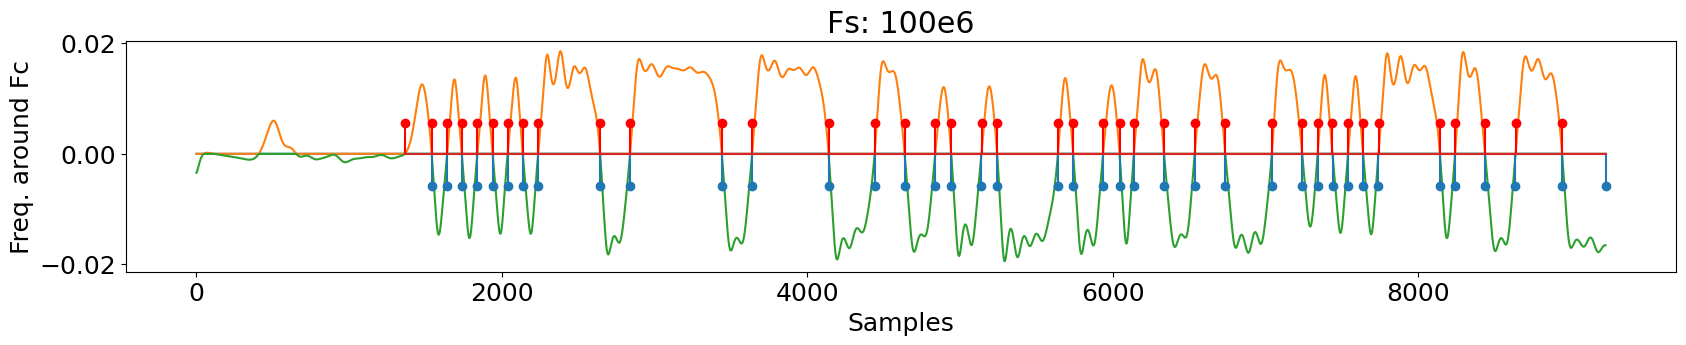

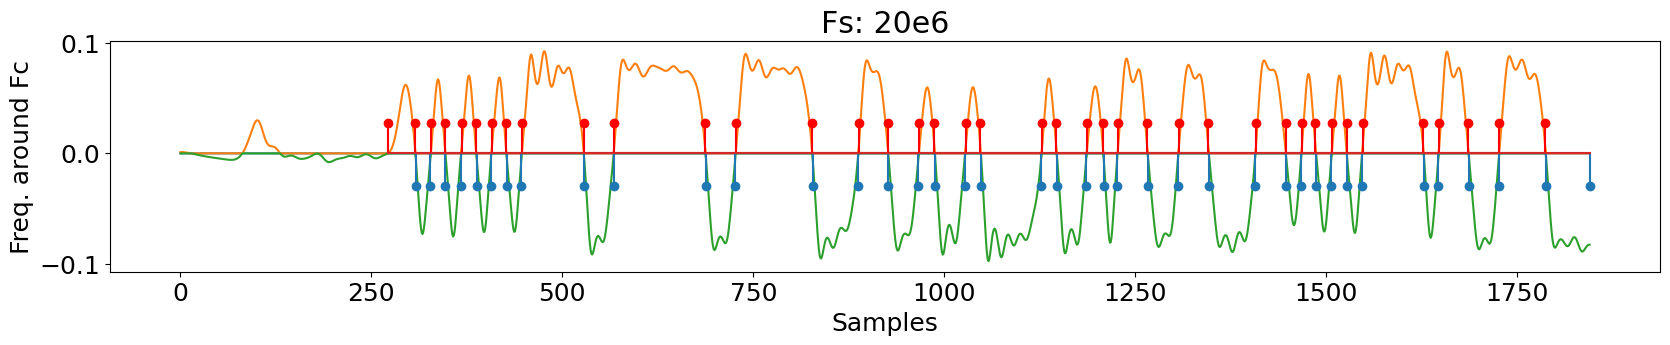

In [65]:
iq = IQ.IQ(Fc=2439810000,Fs=100e6)
plt.rcParams.update({'font.size': 18})

from itertools import groupby
from operator import itemgetter
class bitFinder:

    def keepPositive(self, samples):
        sam = samples.copy()
        sam[sam<0] = 0
        return sam
    def keepNegative(self, samples):
        sam = samples.copy()
        sam[sam>0] = 0
        return sam

    def nonZeroGrouper(self, samples,farmeBiggerThan = 82, frameSmallerThan = 1000 ,Fs = 100e6):
        test_list = np.nonzero(samples)
        framesIndex = []
        for k, g in groupby(enumerate(test_list[0]), lambda ix: ix[0]-ix[1]):
            temp = list(map(itemgetter(1), g))
            if len(temp)< farmeBiggerThan*Fs/100e6 or len(temp)> frameSmallerThan*Fs/100e6:
                continue
            if temp[0] > Fs/100e3: # no bits befor 1000 samples at 100e6 sample rate
                framesIndex.append([temp[0],temp[-1]])
        return np.array(framesIndex)

    def bitPlotter(self, frame,Fs = 100e6, title = '', xlabel = 'Samples', ylabel = 'Freq. around Fc'):
        plt.figure(figsize=(20,3), dpi=100)

        X_positive = self.keepPositive(frame)
        X_negative = self.keepNegative(frame)
        plt.plot(np.zeros(max(len(X_positive),len(X_negative))))
        plt.plot(X_positive)
        plt.plot(X_negative)

        pIndx = self.nonZeroGrouper(X_positive, Fs=Fs)
        nIndx = self.nonZeroGrouper(X_negative, Fs=Fs)
        plt.stem(pIndx.flatten(), [.3*np.max(X_positive)]*len(pIndx.flatten()) ,'r')
        plt.stem(nIndx.flatten(), [.3*np.min(X_negative)]*len(nIndx.flatten()))
        plt.title(title)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.show()
        plt.close()

    def bitFinder(self, sample, Fs= 100e6):
        X_positive = self.keepPositive(sample)
        X_negative = self.keepNegative(sample)
        pIndx = self.nonZeroGrouper(X_positive, Fs=Fs)
        nIndx = self.nonZeroGrouper(X_negative, Fs=Fs)
        pIndx = [{'bit': sample[x[0]:x[1]], 'indxBegining': x[0], 'indxEnd': x[0],'len': x[1] - x[0], 'slope':'positive'} for x in pIndx]
        nIndx = [{'bit': sample[x[0]:x[1]], 'indxBegining': x[0], 'indxEnd': x[0], 'len': x[1] - x[0], 'slope':'negative'} for x in nIndx]
        return pIndx + nIndx


bitPlot = bitFinder()

methods={ 
    iq.gradient:{},
    iq.unwrapPhase:{},
    iq.phase:{}, 
    iq.butter:{},
    iq.demodulate:{},
}
yy = iq.apply(methods=methods, frame = X[0:1])

bitPlot.bitPlotter(yy[0], title='Fs: 100e6')
xx = bitPlot.bitFinder(yy[0], Fs=100e6)

methods={
    iq.gradient:{},
    iq.unwrapPhase:{},
    iq.phase:{}, 
    iq.butter:{'Fs': 20e6},
    iq.downSample:{'downSampleRate':5},
    iq.demodulate:{},
}
yy = iq.apply(methods=methods, frame = X[0:1])

bitPlot.bitPlotter(yy[0], title='Fs: 20e6',Fs=20e6)
xx1 = bitPlot.bitFinder(yy[0], Fs=20e6)



In [52]:
X.iloc[0]['frame'][0:100]

array([ 1.26041444e-02-0.00305185j,  3.96740623e-04+0.01062044j,
       -1.01931822e-02-0.00726341j,  1.14444410e-02-0.00628681j,
        1.22074038e-03+0.01275674j, -1.37638478e-02-0.00759911j,
        1.15359966e-02-0.01046785j,  2.92977691e-03+0.01376385j,
       -1.53813288e-02-0.00479141j,  1.06204413e-02-0.01248207j,
        6.10370189e-03+0.01449629j, -1.70293283e-02+0.00338755j,
        4.79140598e-03-0.01443525j,  1.35196997e-02+0.01226844j,
       -1.72429569e-02+0.00305185j,  1.80059206e-03-0.0184637j ,
        1.63884386e-02+0.01058992j, -2.09662169e-02+0.009888j  ,
        7.62962736e-04-0.01956236j,  1.95623636e-02+0.00686666j,
       -1.55339213e-02+0.01507614j, -5.46281319e-03-0.02145451j,
        2.09967345e-02+0.00531022j, -1.45573290e-02+0.01901303j,
       -1.07425153e-02-0.02026429j,  2.39265114e-02-0.00216681j,
       -8.20947904e-03+0.02316355j, -2.02337727e-02-0.01886044j,
        2.65511032e-02-0.00982696j, -4.18103579e-03+0.02499466j,
       -2.45063640e-02-0.

In [10]:


# %%
model = nn.Sequential(
    bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=6, out_features=1000),
    nn.ReLU(),
    bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=1000, out_features=10000),
    nn.ReLU(),
    bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=10000, out_features=1000),
    nn.ReLU(),
    bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=1000, out_features=13),
)



In [11]:
ce_loss = nn.CrossEntropyLoss()
kl_loss = bnn.BKLLoss(reduction='mean', last_layer_only=False)
kl_weight = 0.01

optimizer = optim.Adam(model.parameters(), lr=0.01)

# %%
kl_weight = 0.1

# %%
for step in range(3000):
    pre = model(x)
    ce = ce_loss(pre, y)
    kl = kl_loss(model)
    cost = ce + kl_weight*kl
    
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()
    
_, predicted = torch.max(pre.data, 1)
total = y.size(0)
correct = (predicted == y).sum()
print('- Accuracy: %f %%' % (100 * float(correct) / total))
print('- CE : %2.2f, KL : %2.2f' % (ce.item(), kl.item()))

NameError: name 'x' is not defined